# Data Challenge - Salary Dataset (Alan Au)

### Assignment Description:

It’s helpful if we can suggest an approximate salary to job seekers for a given job post. Unfortunately, not all job postings designate the salary. This is where you come in: Your first task is to develop a salary prediction system.

The goal: provide estimated salaries for a new job posting.


### Data supplied:

You are given three CSV (comma--separated) data files:

* train_features_DATE.csv: Each row represents metadata for an individual job posting. The “jobId” column represents a unique identifier for the job posting. The remaining columns describe features of the job posting.
* train_salaries_DATE.csv: Each row associates a “jobId” with a “salary”.
* test_features_DATE.csv: Similar to train_features_DATE.csv, each row represents metadata for an individual job posting.

The first row of each file contains headers for the columns. Keep in mind that the metadata and
salary data has been extracted by our aggregation and parsing systems. As such, it’s possible
that the data is dirty (may contain errors).

### The task

You must build a model to predict the salaries for the job postings contained in test_features_DATE.csv. The output of your system should be a CSV file entitled **test_salaries.csv** where each row has the following format: jobId, salary
As a reference, your output should mirror the format of train_salaries_DATE.csv.

# Alan's Notes

* Import packages and files
* Inspect files
* Summarize and visualize data
* Choose model (probably a Random Forest Regressor)
* Train/test split on training data? (not needed for Random Forest)
* Evaluate model (out of bag)
* Get feature importance listing
* Run test data
* Cleanup and presentation

In [109]:
#!/usr/bin/python3
__author__ = 'Alan Au'
__date__   = '2018-04-09'

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,5] #make the plots bigger and easier to read

#from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#seed = int(random.random()*10000) #generate a random number between 0 and 10000
seed = 7979 #for consistency during testing, just keep the same pseudorandomly generated seed
print("Pseudorandom seed is:",seed)

Pseudorandom seed is: 7979


In [162]:
data_loc = './Salaries/' #path to my data file subdirectory; must end with '/'

# pre-specified
f_train_x = data_loc + 'test_features_2013-03-07.csv'
f_train_y = data_loc + 'train_salaries_2013-03-07.csv'
f_test_x = data_loc + 'test_features_2013-03-07.csv'

# generate this
f_test_y = data_loc + 'test_salaries.csv'

# for reference
headers_x = ['jobId','companyId','jobType','degree','major','industry','yearsExperience','milesFromMetropolis']
headers_y = ['jobId','salary']

# load data
# Treat 'NONE' as missing data for now--if it's meaningful, can re-import as-is.
explore_x_df = pd.read_csv(f_train_x, header='infer', na_values='NONE')
explore_y_df = pd.read_csv(f_train_y, header='infer', na_values='NONE')

In [163]:
# Check for missing/'NONE' values.
explore_x_df.count()

jobId                  1000000
companyId              1000000
jobType                1000000
degree                  762533
major                   465932
industry               1000000
yearsExperience        1000000
milesFromMetropolis    1000000
dtype: int64

In [164]:
# this time, keep the 'NONE' values
train_x_df = pd.read_csv(f_train_x, header='infer')
train_y_df = pd.read_csv(f_train_y, header='infer')
test_x_df = pd.read_csv(f_test_x, header='infer')

In [165]:
# Check a few random rows to make sure I loaded this correctly
train_x_df.sample(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
212869,JOB1362685620556,COMP0,CFO,NONE,NONE,EDUCATION,10,40
890994,JOB1362686298681,COMP25,CTO,DOCTORAL,LITERATURE,HEALTH,21,38
529023,JOB1362685936710,COMP36,VICE_PRESIDENT,NONE,NONE,AUTO,13,18
929974,JOB1362686337661,COMP53,VICE_PRESIDENT,HIGH_SCHOOL,NONE,HEALTH,16,11
130753,JOB1362685538440,COMP45,MANAGER,DOCTORAL,CHEMISTRY,AUTO,2,89
305926,JOB1362685713613,COMP14,VICE_PRESIDENT,HIGH_SCHOOL,NONE,AUTO,24,60
246864,JOB1362685654551,COMP45,CFO,NONE,NONE,EDUCATION,10,96
765882,JOB1362686173569,COMP46,JANITOR,NONE,NONE,WEB,15,88
426050,JOB1362685833737,COMP51,SENIOR,DOCTORAL,ENGINEERING,HEALTH,4,3
503181,JOB1362685910868,COMP42,VICE_PRESIDENT,DOCTORAL,CHEMISTRY,HEALTH,22,87


In [166]:
# Verify count for outputs
train_y_df.count()

jobId     1000000
salary    1000000
dtype: int64

In [181]:
# What are all of the job types?
jobTypes = train_x_df['jobType']
jobTypes.value_counts()

VICE_PRESIDENT    125434
JANITOR           125253
SENIOR            125202
CFO               125092
JUNIOR            125022
CEO               124941
CTO               124665
MANAGER           124391
Name: jobType, dtype: int64

In [182]:
# What are all of the degrees?
degrees = train_x_df['degree']
degrees.value_counts()

HIGH_SCHOOL    238255
NONE           237467
MASTERS        175236
DOCTORAL       175105
BACHELORS      173937
Name: degree, dtype: int64

In [183]:
# What are all of the majors?
majors = train_x_df['major']
majors.value_counts()

NONE           534068
BIOLOGY         58804
ENGINEERING     58496
COMPSCI         58385
PHYSICS         58248
CHEMISTRY       58159
LITERATURE      58062
BUSINESS        57961
MATH            57817
Name: major, dtype: int64

In [225]:
# What are all of the industries?
industries = train_x_df['industry']
industries.value_counts()

SERVICE      143161
FINANCE      143101
WEB          143012
HEALTH       142978
EDUCATION    142731
OIL          142535
AUTO         142482
Name: industry, dtype: int64

In [226]:
# What's the range of years experience?
train_x_df.sort_values(by=['yearsExperience'])
years = train_x_df['yearsExperience']
# List the yearsExperience and their count
years.value_counts().sort_index()
#plt.hist(years,bins=25);

0     39853
1     40152
2     40174
3     39725
4     39945
5     39832
6     40311
7     40403
8     40180
9     39720
10    39746
11    39802
12    39973
13    39892
14    39951
15    40094
16    40045
17    40060
18    39737
19    40028
20    40190
21    40034
22    40018
23    40084
24    40051
Name: yearsExperience, dtype: int64

In [233]:
# What's the range of miles from metropolis?
dists = train_x_df['milesFromMetropolis']
dists.value_counts().sort_index()

0     10130
1     10086
2     10177
3     10019
4     10086
5     10036
6      9824
7      9995
8      9949
9      9891
10    10031
11     9982
12     9883
13    10163
14    10096
15     9979
16     9998
17    10007
18     9755
19     9908
20    10054
21     9948
22    10015
23     9973
24     9842
25    10166
26     9992
27    10046
28     9994
29     9913
      ...  
70     9816
71     9997
72    10066
73    10086
74    10019
75    10054
76    10158
77    10042
78    10031
79    10129
80    10261
81    10035
82    10033
83     9788
84     9916
85    10020
86     9925
87    10114
88     9926
89    10045
90    10060
91    10088
92     9908
93     9922
94    10017
95    10205
96    10144
97    10010
98     9984
99     9998
Name: milesFromMetropolis, Length: 100, dtype: int64

# More feature exploration

In [178]:
# What's my distribution of jobTypes without a major?
jobTypes_no_maj = train_x_df[train_x_df['major'] == 'NONE']['jobType']
jobTypes_no_maj.value_counts()

JANITOR           125253
VICE_PRESIDENT     58825
SENIOR             58580
JUNIOR             58472
MANAGER            58348
CFO                58247
CEO                58196
CTO                58147
Name: jobType, dtype: int64

In [179]:
# What's my distribution of jobTypes without a degree?
jobTypes_no_deg = train_x_df[train_x_df['degree'] == 'NONE']['jobType']
jobTypes_no_deg.value_counts()

JANITOR           62551
SENIOR            25244
VICE_PRESIDENT    25120
CEO               25057
JUNIOR            24975
CFO               24882
MANAGER           24861
CTO               24777
Name: jobType, dtype: int64

# Salary data

In [93]:
# What's the range of salaries?
salaries = set(train_y_df['salary'])
(min(salaries), max(salaries))

(0, 301)

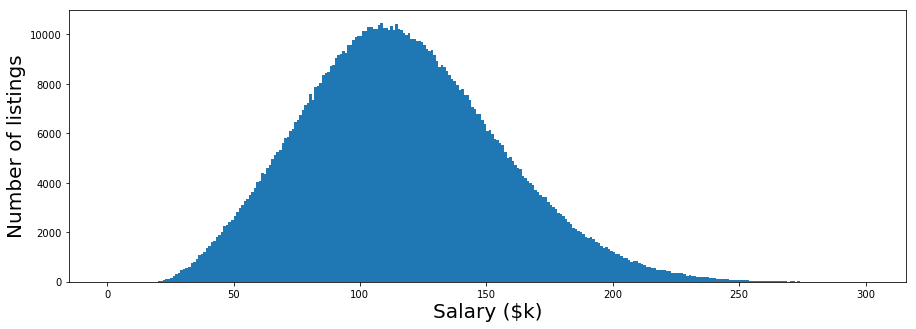

In [113]:
# What's the distribution of salary data?

plt.hist(sorted(train_y_df['salary']), bins=301); #based on salary range
plt.xlabel('Salary ($k)', fontsize = '20');
plt.ylabel('Number of listings', fontsize = '20');

In [114]:
# Any 0-salary listings in our training set?
train_y_df[train_y_df['salary']<=0].count()

jobId     5
salary    5
dtype: int64

In [159]:
# What about really low-salary listings in our training set?
train_y_df[train_y_df['salary']<=5].count()  # Pick some low threshold, like 5k annual salary.

jobId     5
salary    5
dtype: int64

In [236]:
# Probably bad data, but let's check.
train_x_df[train_y_df['salary']<=5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362685438246,COMP20,MANAGER,DOCTORAL,NONE,WEB,20,58
495984,JOB1362685903671,COMP8,CEO,HIGH_SCHOOL,NONE,EDUCATION,16,45
652076,JOB1362686059763,COMP44,CEO,MASTERS,MATH,WEB,19,46
816129,JOB1362686223816,COMP34,VICE_PRESIDENT,MASTERS,COMPSCI,SERVICE,23,66
828156,JOB1362686235843,COMP12,CFO,BACHELORS,NONE,SERVICE,5,86


In [235]:
# Keep data where salary is in a reasonable range (i.e. >5). Also keep 'NONE' values.
clean_y_df = train_y_df[train_y_df['salary']>=5]
clean_x_df = train_x_df[train_y_df['salary']>=5]
clean_x_df.count()

jobId                  999995
companyId              999995
jobType                999995
degree                 999995
major                  999995
industry               999995
yearsExperience        999995
milesFromMetropolis    999995
dtype: int64

## Data Exploration Notes

The feature data contains 'NONE' values. In cases where the degree is "High School" then there's no corresponding major, which is expected. 

Currently, it's about 24% of the 'degree' data and 54% of the 'major' data. It's a large enough percentage that I don't want to drop it, it appears to be distributed across the dataset, and if I use a tree-based model, it may end being useful. But if the model performs badly, I may re-evaluate.

On the other hand, 0-salary results are not useful, and there are so few that it's probably safe to drop them.